In [1]:
import os
import cv2
from torchvision import datasets
import torchvision
import torch
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
Image.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [2]:
protext = './face_detector/deploy.prototxt'
weights = './face_detector/res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNet(protext, weights)

In [3]:
print("[INFO] loading face mask detector model...")
model = torch.load('./trained-models/model_final.pth')
#model.eval()

[INFO] loading face mask detector model...


In [4]:
class_names = ['Mask', 'No Mask']

def predict(image):
    prediction_transform = transforms.Compose([
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    
    #model.eval()
    prob = model(image)
    idx = torch.argmax(prob)
    
    return idx, prob, class_names[idx]

[INFO] computing face detections...


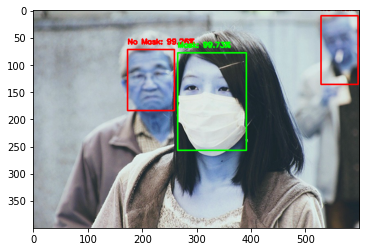

In [9]:
image = cv2.imread('./examples/example_03.png')
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

for i in range(0, detections.shape[2]):
    
    confidence = detections[0, 0, i, 2]
    
    if confidence > 0.3:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        
        idx, prob, out = predict(face)
        
        plt.imshow(image)
        
        #print(idx, prob[0][idx].item()*100, out)
        color = (0, 255, 0) if out == "Mask" else (255, 0, 0)


        label = "{}: {:.2f}%".format(out, prob[0][idx].item()*100)


        cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        
plt.imshow(image)